In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [ ]:
try:
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("Please upload the 'creditcard.csv' file.")
    exit()


print("Class distribution:\n", df['Class'].value_counts(normalize=True))

# Preprocessing
X = df.drop(['Time', 'Class'], axis=1)  # 'Time' isn't useful here
y = df['Class']

Class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [ ]:
# Scaling amount feature
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))

# Splitting dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=512,
                    verbose=2)

Epoch 1/10
357/357 - 8s - 21ms/step - accuracy: 0.9792 - loss: 0.1245 - val_accuracy: 0.9992 - val_loss: 0.0251
Epoch 2/10
357/357 - 6s - 16ms/step - accuracy: 0.9990 - loss: 0.0160 - val_accuracy: 0.9993 - val_loss: 0.0078
Epoch 3/10
357/357 - 1s - 3ms/step - accuracy: 0.9992 - loss: 0.0083 - val_accuracy: 0.9993 - val_loss: 0.0050
Epoch 4/10
357/357 - 1s - 4ms/step - accuracy: 0.9992 - loss: 0.0060 - val_accuracy: 0.9993 - val_loss: 0.0041
Epoch 5/10
357/357 - 2s - 4ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 6/10
357/357 - 2s - 6ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9993 - val_loss: 0.0036
Epoch 7/10
357/357 - 1s - 4ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 8/10
357/357 - 1s - 3ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 9/10
357/357 - 1s - 3ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0034

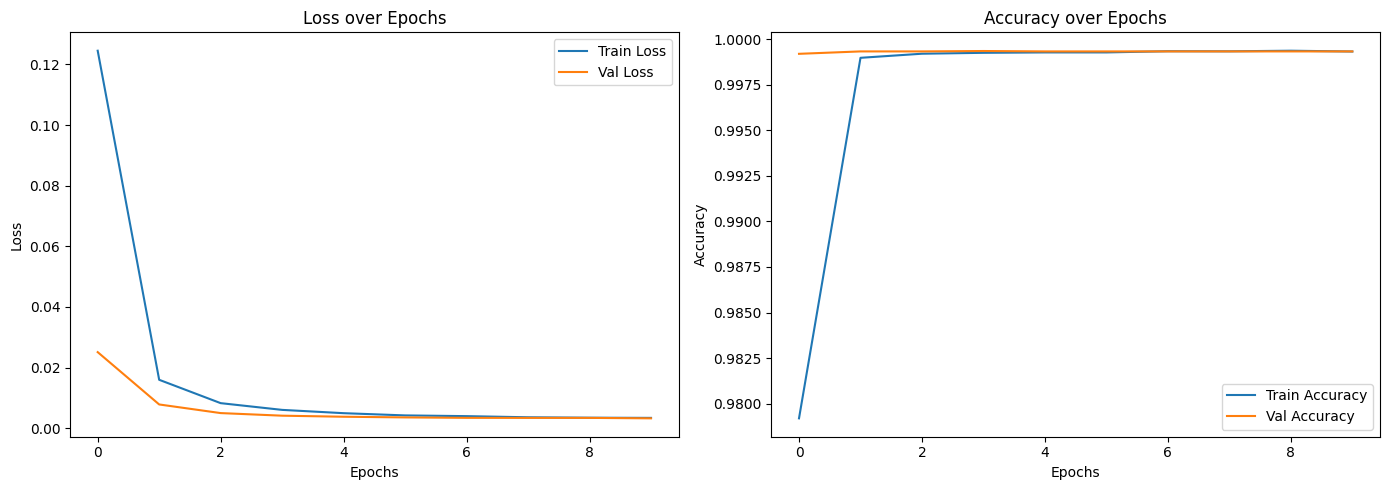

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Confusion Matrix:


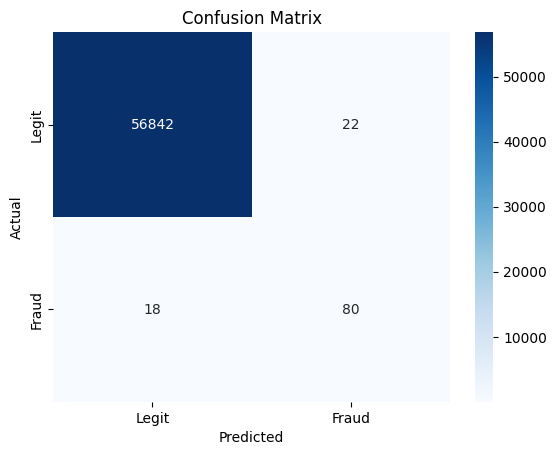


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Detailed Metrics:
Accuracy:              0.9993
Precision:             0.7843
Recall (TPR):          0.8163
F1 Score:              0.8000
False Positive Rate:   0.0004
True Negative Rate:    0.9996
False Negative Rate:   0.1837
ROC AUC Score:         0.9738
Precision-Recall AUC:  0.7533


In [ ]:
# Evaluation
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Realted metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_probs)
pr_auc = average_precision_score(y_test, y_pred_probs)

tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
fnr = fn / (fn + tp) if (fn + tp) != 0 else 0


print("\nConfusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Detailed Metrics:")
print(f"Accuracy:              {accuracy:.4f}")
print(f"Precision:             {precision:.4f}")
print(f"Recall (TPR):          {recall:.4f}")
print(f"F1 Score:              {f1:.4f}")
print(f"False Positive Rate:   {fpr:.4f}")
print(f"True Negative Rate:    {tnr:.4f}")
print(f"False Negative Rate:   {fnr:.4f}")
print(f"ROC AUC Score:         {roc_auc:.4f}")
print(f"Precision-Recall AUC:  {pr_auc:.4f}")


In [ ]:
print(df['Class'].value_counts(normalize=True))


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [ ]:
model.save("fraud_detection_model.h5")

model_json = model.to_json()

with open("fraud_detection_model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
def predict_transaction(*args):
    features = np.array(args).reshape(1, -1)
    features[:, -1] = scaler.transform(features[:, -1].reshape(-1, 1))  # scale 'Amount'
    prob = model.predict(features)[0][0]
    if prob > 0.5:
        return f" Fraudulent Transaction (Probability: {prob:.4f})"
    else:
        return f" Legitimate Transaction (Probability: {1 - prob:.4f})"

# Gradio UI
inputs = [gr.Slider(minimum=-30, maximum=30, value=0, label=f'V{i}') for i in range(1, 29)]
inputs.append(gr.Number(label='Amount'))

iface = gr.Interface(fn=predict_transaction,
                     inputs=inputs,
                     outputs=gr.Textbox(label="Prediction"),
                     title="Credit Card Fraud Detection",
                     description="Input V1–V28 features and Amount to predict if a transaction is fraudulent.")

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://890a92145d8caad4d9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
